In [1]:
import pandas as pd
import cv2
from os import walk
import numpy as np
import matplotlib.pyplot as plt
import time
import heapq
from datetime import timedelta
from sklearn.cluster import AgglomerativeClustering
import multiprocessing

In [2]:
class Vertex():  # for PRM
    def __init__(self, idx, x, y):
        self.idx = idx
        self.x = x
        self.y = y

class Node():  # for tree
    def __init__(self, idx, x, y, parent_idx=None):
        self.idx = idx
        self.x = x
        self.y = y
        self.parent_idx = parent_idx
        

def not_connected(V, E, vertex):
    V_num = len(V.keys())
    connected_set = set()
    queue = [vertex]
    while queue:
        idx = queue.pop()
        connected_set.add(idx)
        for neighbor_idx in E[idx]:
            if neighbor_idx not in connected_set:
                queue.append(neighbor_idx)
    
    return connected_set ^ set(V.keys())
                
def path_good(chart, pos0, pos1, increment):
    x0, y0 = pos0
    x1, y1 = pos1
    dist = np.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    direction = [(x1-x0)/dist, (y1-y0)/dist]
    for i in range(1, int(dist//increment), increment):
        if chart[int(y0+direction[1]*i*increment)][int(x0+direction[0]*i*increment)][0] > 0:
            return False
    
    return True

def geo_to_pixel(chart, geo_position, extent):
    lon_0, lon_1, lat_0, lat_1 = extent
    
    x_geo = geo_position[0]
    y_geo = geo_position[1]
    x_geo_range = lon_1 - lon_0
    y_geo_range = lat_1 - lat_0
    
    x_pixel = int((x_geo - lon_0) / x_geo_range * chart.shape[1])
    y_pixel = int((lat_1 - y_geo) / y_geo_range * chart.shape[0])
    
    pos_in_pixel = (x_pixel, y_pixel)
    return pos_in_pixel

def get_phi(x0, y0, x1, y1, l_local):
    x_disp = (x1 - x0)
    if x_disp > l_local:
        x_disp = l_local
    if x_disp < - l_local:
        x_disp = - l_local

    if y1 - y0 > 0:
        phi = np.arccos(x_disp / l_local)
    else:
        phi = 2*np.pi - np.arccos(x_disp / l_local)
    return phi

def draw_path(chart, path, color=None, width=None):
    if not color:
        color = (0, 255, 0)
    if not width:
        width = 5
    for i in range(len(path) - 1):
        start_point = path[i]
        end_point = path[i+1]
        cv2.line(chart, start_point, end_point, color, width)

def draw_ship(chart, pos, course_in_degree, scale, color):
    x, y = pos
    phi = (course_in_degree - 90) * np.pi / 180
    ship_contour = scale * np.matrix([[30, 0], 
                                      [10, -10], 
                                      [-30, -10], 
                                      [-30, 10], 
                                      [10, 10]]).T
    rot = np.matrix([[np.cos(phi), -np.sin(phi)], 
                     [np.sin(phi), np.cos(phi)]])
    ship_contour = np.round(np.matmul(rot, ship_contour)).astype(int)
    
    for i in range(5):
        ship_contour[0, i] += x
        ship_contour[1, i] += y
        
    cv2.fillPoly(chart, pts=[ship_contour.T], color=color)
    
    return chart

def draw_square(chart, pos, scale, color):
    x, y = pos
    ship_contour = scale * np.matrix([[20, -20], 
                                      [-20, -20], 
                                      [-20, 20], 
                                      [20, 20]]).T
    
    for i in range(4):
        ship_contour[0, i] += x
        ship_contour[1, i] += y
        
    cv2.fillPoly(chart, pts=[ship_contour.T], color=color)
    
    return chart

In [3]:
directory = "../nautical_chart/"
df_description = pd.read_csv(directory+"chart_detail.csv")
print(df_description)

resolution, x_km_per_deg, y_km_per_deg, lon_0, lon_1, lat_0, lat_1 = df_description.loc[0, :]
extent = (lon_0, lon_1, lat_0, lat_1)

   res  x_km_per_deg  y_km_per_deg   lon_0   lon_1  lat_0  lat_1
0  100         87.81        111.19 -122.67 -122.22  37.54  38.17


In [4]:
# read test cases
test_cases = {4: ["21:56:57", "22:59:56"], 
              5: ["21:03:23", "22:46:24"], 
              6: ["21:49:05", "22:23:13"], 
              12: ["21:00:25", "22:29:55"], 
              19: ["22:06:13", "22:52:11"], 
              25: ["22:12:47", "22:50:18"]}
date = 4
risk_coef = 20000

begin = test_cases[date][0]
end = test_cases[date][1]

chart_path = "../nautical_chart/res_100_lon_-122.67_-122.22_lat_37.54_38.17.jpg"
chart = cv2.imread(chart_path)

# read test cases
test_case_path = "../test_cases/"
df_test_cases = pd.read_csv(test_case_path + "test_cases.csv")
own_mmsi = int(df_test_cases.loc[date-1, "own_mmsi"])
if date < 10:
    filename = "AIS_2020_07_0" + str(date) + ".csv"
else:
    filename = "AIS_2020_07_" + str(date) + ".csv"
csv_directory = "../processed_data/"
df = pd.read_csv(csv_directory + filename)

# define start and end time, and read AIS data in this time period
start_time = pd.to_datetime('2020-07-' + filename[-6:-4] + ' ' + begin) 
end_time = pd.to_datetime('2020-07-' + filename[-6:-4] + ' ' + end)

ship_dict = {}  # ship_dict[MMSI]: list of [BaseDateTime, LAT, LON, SOG, COG]
for i in range(df.shape[0]):
    MMSI, BaseDateTime, LAT, LON, SOG, COG, Heading = df.loc[i, :]
    if MMSI == own_mmsi and (pd.to_datetime(BaseDateTime) < start_time or pd.to_datetime(BaseDateTime) > end_time):
        continue
    if start_time - timedelta(hours=1) <= pd.to_datetime(BaseDateTime) <= end_time + timedelta(hours=1):
        if MMSI not in ship_dict:
            ship_dict[MMSI] = []
        ship_dict[MMSI].append([BaseDateTime, LAT, LON, SOG, COG])
for key in ship_dict:
    ship_dict[key].sort(key=lambda x : x[0])

# print(ship_dict[own_mmsi])

# get the start position, SOG, COG, and goal position
start_pos_geo = ship_dict[own_mmsi][0][2], ship_dict[own_mmsi][0][1]
goal_pos_geo = ship_dict[own_mmsi][-1][2], ship_dict[own_mmsi][-1][1]
start_pos = geo_to_pixel(chart, start_pos_geo, extent)
start_SOG = ship_dict[own_mmsi][0][3]
start_COG = ship_dict[own_mmsi][0][4]
goal_pos = geo_to_pixel(chart, goal_pos_geo, extent)
    
own_speed = start_SOG * 0.514444 * resolution / 1000 # in pixels/s

########################################################################
test id:  0
human path(yellow) length in pixels:  2961.936852736073
my path(green) length in pixels:  3109.9109933452387
non_pred path(red) length in pixels:  3040.5528003727177
my path, sum(p_local):  5.5976617443741725 , max(p_local):  0.4151515927081225
non_pred path, sum(p_local):  6.276458989647686 , max(p_local):  0.3822757322900687
human path, sum(p_local):  2.1050991182962324 , max(p_local):  0.17277237767257855
human path's min distance to other ships in pixels:  13.503607944305454
human path's number of encounters:  13
my path's min distance to other ships in pixels:  14.497534934060411
my path's number of encounters:  9
non_pred path's min distance to other ships in pixels:  10.504285644716358
non_pred path's number of encounters:  10


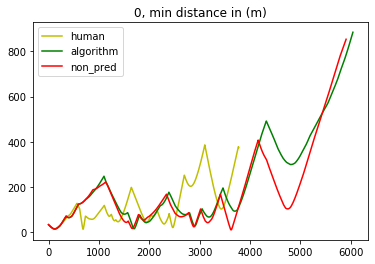

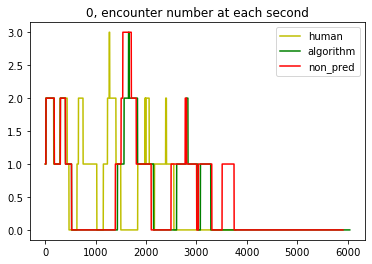

my algorithm, encounter >= 1: 1865 (s), encounter >= 2:  571 , encounter >= 3:  9
non predion, encounter >= 1: 2245 (s), encounter >= 2:  594 , encounter >= 3:  169

########################################################################
test id:  1


In [ ]:
# read final own path

# list of encountered numbers >=1, >=2, >=3 for each test case
my_1_list = []
my_2_list = []
my_3_list = []
non_pred_1_list = []
non_pred_2_list = []
non_pred_3_list = []

# list of path length, max(p_local), sum(p_local) for each test case
my_path_length_list = []
my_max_p_local_list = []
my_sum_p_local_list = []
non_pred_path_length_list = []
non_pred_max_p_local_list = []
non_pred_sum_p_local_list = []

my_time_list = []
non_pred_time_list = []

my_image = chart.copy()
non_pred_image = chart.copy()

test_id_range = list(range(10))
for test_id in test_id_range:
    print("########################################################################")
    print("test id: ", test_id)
    
#     result_directory_with_pred = "results/07_04(max)/" + str(test_id) + "/with_prediction/"
#     result_directory_without_pred = "results/07_04(max)/" + str(test_id) + "/without_prediction/"
    if date == 4:
        if risk_coef == 10000:
            result_directory_with_pred = "results/07_04(sum)/" + str(test_id) + "/with_prediction/"
            result_directory_without_pred = "results/07_04(sum)/" + str(test_id) + "/without_prediction/"
        elif risk_coef == 12000:
            result_directory_with_pred = "results/07_04(sum1)/" + str(test_id) + "/with_prediction/"
            result_directory_without_pred = "results/07_04(sum1)/" + str(test_id) + "/without_prediction/"
        else:
            risk_coef = 20000
            result_directory_with_pred = "results/07_04/" + str(test_id) + "/with_prediction/"
            result_directory_without_pred = "results/07_04/" + str(test_id) + "/without_prediction/"
    else:  # if date == 6
        if risk_coef == 10000:
            result_directory_with_pred = "results/07_06(sum)/" + str(test_id) + "/with_prediction/"
            result_directory_without_pred = "results/07_06(sum)/" + str(test_id) + "/without_prediction/"
        elif risk_coef == 12000:
            result_directory_with_pred = "results/07_06(sum1)/" + str(test_id) + "/with_prediction/"
            result_directory_without_pred = "results/07_06(sum1)/" + str(test_id) + "/without_prediction/"
        else:
            risk_coef = 20000
            result_directory_with_pred = "results/07_06/" + str(test_id) + "/with_prediction/"
            result_directory_without_pred = "results/07_06/" + str(test_id) + "/without_prediction/"
    
    final_own_path_with_pred = []
    with open(result_directory_with_pred + "/log/final_own_path.txt") as f:
        Lines = f.readlines()
        for line in Lines:
            x_str, y_str = line.split(",")
            x, y = int(x_str), int(y_str)
            final_own_path_with_pred.append([x, y])

    final_own_path_without_pred = []
    with open(result_directory_without_pred + "/log/final_own_path.txt") as f:
        Lines = f.readlines()
        for line in Lines:
            x_str, y_str = line.split(",")
            x, y = int(x_str), int(y_str)
            final_own_path_without_pred.append([x, y])

    draw_path(my_image, final_own_path_with_pred, color=[0, 255, 0], width=10)
    draw_path(non_pred_image, final_own_path_without_pred, color=[0, 0, 255], width=10)
            
#######################################################################################################
    # interpolate the path of all target ships
    ship_dict = {}  # ship_dict[MMSI]: list of [BaseDateTime, LAT, LON, SOG, COG]
    for i in range(df.shape[0]):
        MMSI, BaseDateTime, LAT, LON, SOG, COG, Heading = df.loc[i, :]
        if start_time - timedelta(hours=1) <= pd.to_datetime(BaseDateTime) <= end_time + timedelta(hours=1):
            if MMSI not in ship_dict:
                ship_dict[MMSI] = []
            ship_dict[MMSI].append([BaseDateTime, LAT, LON, SOG, COG])
    for key in ship_dict:
        ship_dict[key].sort(key=lambda x : x[0])    

    interpolated_path = {}
    for mmsi in ship_dict:
        interpolated_path[mmsi] = {}
        for i in range(len(ship_dict[mmsi]) - 1):
            BaseDateTime, LAT, LON, SOG, COG = ship_dict[mmsi][i]
            t0 = (pd.to_datetime(BaseDateTime) - start_time).seconds + (pd.to_datetime(BaseDateTime) - start_time).days *24*3600
            x0, y0 = geo_to_pixel(chart, [LON, LAT], extent)

            BaseDateTime, LAT, LON, SOG, COG = ship_dict[mmsi][i+1]
            t1 = (pd.to_datetime(BaseDateTime) - start_time).seconds + (pd.to_datetime(BaseDateTime) - start_time).days *24*3600
            x1, y1 = geo_to_pixel(chart, [LON, LAT], extent)

            if t0 == t1:
                continue
            for j in range(t0, t1+1):
                interpolated_path[mmsi][j] = [x0+(x1-x0)*(j-t0)/(t1-t0), y0+(y1-y0)*(j-t0)/(t1-t0)]

    # path with prediction
    interpolated_own_path = {}
    # final_own_path = own_path[-1]
    final_arrival_time = [0]
    for i in range(len(final_own_path_with_pred)-1):
        x0, y0 = final_own_path_with_pred[i]
        x1, y1 = final_own_path_with_pred[i+1]
        dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        delta_t = dist / own_speed
        final_arrival_time.append(final_arrival_time[-1] + delta_t)
    for i in range(int(final_arrival_time[-1])):
        for j in range(len(final_arrival_time) - 1):
            if final_arrival_time[j] <= i and final_arrival_time[j+1] > i:
                break
        x0, y0 = final_own_path_with_pred[j]
        x1, y1 = final_own_path_with_pred[j+1]
        t0 = final_arrival_time[j]
        t1 = final_arrival_time[j+1]
        interpolated_own_path[i] = [x0+(x1-x0)*(i-t0)/(t1-t0), y0+(y1-y0)*(i-t0)/(t1-t0)]


    # path without prediction
    interpolated_own_path_without_pred = {}
    # final_own_path = own_path[-1]
    final_arrival_time_without_pred = [0]
    for i in range(len(final_own_path_without_pred)-1):
        x0, y0 = final_own_path_without_pred[i]
        x1, y1 = final_own_path_without_pred[i+1]
        dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        delta_t = dist / own_speed
        final_arrival_time_without_pred.append(final_arrival_time_without_pred[-1] + delta_t)

    for i in range(int(final_arrival_time_without_pred[-1])):
        for j in range(len(final_arrival_time_without_pred) - 1):
            if final_arrival_time_without_pred[j] <= i and final_arrival_time_without_pred[j+1] > i:
                break
        x0, y0 = final_own_path_without_pred[j]
        x1, y1 = final_own_path_without_pred[j+1]
        t0 = final_arrival_time_without_pred[j]
        t1 = final_arrival_time_without_pred[j+1]
        interpolated_own_path_without_pred[i] = [x0+(x1-x0)*(i-t0)/(t1-t0), y0+(y1-y0)*(i-t0)/(t1-t0)]

        
        
#######################################################################################################        
    # compare the length of path
    human_path = []
    for BaseDateTime, LAT, LON, SOG, COG in ship_dict[own_mmsi]:
        if start_time <= pd.to_datetime(BaseDateTime) <= end_time:
            human_path.append(geo_to_pixel(chart, [LON, LAT], extent))

    human_dist = 0
    for i in range(len(human_path) - 1):
        x0, y0 = human_path[i]
        x1, y1 = human_path[i+1]
        dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        human_dist += dist

    my_dist = 0
    for i in range(len(final_own_path_with_pred) - 1):
        x0, y0 = final_own_path_with_pred[i]
        x1, y1 = final_own_path_with_pred[i+1]
        dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        my_dist += dist

    my_dist_without_pred = 0
    for i in range(len(final_own_path_without_pred) - 1):
        x0, y0 = final_own_path_without_pred[i]
        x1, y1 = final_own_path_without_pred[i+1]
        dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        my_dist_without_pred += dist

    print("human path(yellow) length in pixels: ", human_dist)
    print("my path(green) length in pixels: ", my_dist)
    print("non_pred path(red) length in pixels: ", my_dist_without_pred)

    my_path_length_list.append(my_dist)
    non_pred_path_length_list.append(my_dist_without_pred)\
    
#     image = chart.copy()
#     draw_path(image, final_own_path_with_pred, color=[0, 255, 0], width=10)
#     draw_path(image, final_own_path_without_pred, color=[0, 0, 255], width=10)
#     draw_path(image, human_path, color=[0, 255, 255], width=10)


#     image = cv2.resize(image, [image.shape[1] // 10, image.shape[0] // 10])
#     cv2.imshow("image", image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()


#######################################################################################################
    # compare the p_local and max(p_local) cost
    my_phi_list = []
    for i in range(len(final_own_path_with_pred) - 1):
        x0, y0 = final_own_path_with_pred[i]
        x1, y1 = final_own_path_with_pred[i+1]
        dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        if dist == 0:
            continue
        phi = get_phi(x0, y0, x1, y1, dist)
        my_phi_list.append(phi)

    my_p_local_list = []
    for i in range(len(my_phi_list) - 1):
        phi0 = my_phi_list[i]
        phi1 = my_phi_list[i+1]
        p_local = abs(np.tan(0.5 * (phi0 - phi1)))
        my_p_local_list.append(p_local)
    print("my path, sum(p_local): ", sum(my_p_local_list), ", max(p_local): ", max(my_p_local_list))
    my_max_p_local_list.append(max(my_p_local_list))
    my_sum_p_local_list.append(sum(my_p_local_list))

    my_phi_list_without_pred = []
    for i in range(len(final_own_path_without_pred) - 1):
        x0, y0 = final_own_path_without_pred[i]
        x1, y1 = final_own_path_without_pred[i+1]
        dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        if dist == 0:
            continue
        phi = get_phi(x0, y0, x1, y1, dist)
        my_phi_list_without_pred.append(phi)

    my_p_local_list_without_pred = []
    for i in range(len(my_phi_list_without_pred) - 1):
        phi0 = my_phi_list_without_pred[i]
        phi1 = my_phi_list_without_pred[i+1]
        p_local = abs(np.tan(0.5 * (phi0 - phi1)))
        my_p_local_list_without_pred.append(p_local)
    print("non_pred path, sum(p_local): ", sum(my_p_local_list_without_pred), ", max(p_local): ", max(my_p_local_list_without_pred))
    non_pred_max_p_local_list.append(max(my_p_local_list_without_pred))
    non_pred_sum_p_local_list.append(sum(my_p_local_list_without_pred))


    human_phi_list = []
    for i in range(len(ship_dict[own_mmsi]) - 1):
        BaseDateTime, LAT, LON, SOG, COG = ship_dict[own_mmsi][i]
        t0 = (pd.to_datetime(BaseDateTime) - start_time).seconds + (pd.to_datetime(BaseDateTime) - start_time).days *24*3600
        x0, y0 = geo_to_pixel(chart, [LON, LAT], extent)
        if pd.to_datetime(BaseDateTime) < start_time:
            continue

        BaseDateTime, LAT, LON, SOG, COG = ship_dict[own_mmsi][i+1]
        t1 = (pd.to_datetime(BaseDateTime) - start_time).seconds + (pd.to_datetime(BaseDateTime) - start_time).days *24*3600
        x1, y1 = geo_to_pixel(chart, [LON, LAT], extent)
        if pd.to_datetime(BaseDateTime) > end_time:
            break

        dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        if dist == 0:
            continue
        phi = get_phi(x0, y0, x1, y1, dist)
        human_phi_list.append(phi)

    human_p_local_list = []
    for i in range(len(human_phi_list) - 1):
        phi0 = human_phi_list[i]
        phi1 = human_phi_list[i+1]
        p_local = abs(np.tan(0.5 * (phi0 - phi1)))
        human_p_local_list.append(p_local)
    print("human path, sum(p_local): ", sum(human_p_local_list), ", max(p_local): ", max(human_p_local_list))

    
    
    
#######################################################################################################
    # compare the min dist to other ships
    encounter_range_nm = 0.5
    encounter_range = int(1852 * encounter_range_nm * resolution / 1000)



    min_dist = 100000
    human_dist_list = []
    human_encounter_count_list = []
    human_encounter_set = set()
    for i in range((end_time - start_time).seconds):
        cur_min_dist = 100000
        x0, y0 = interpolated_path[own_mmsi][i]
        encounter_count = 0
        for mmsi in interpolated_path:
            if mmsi != own_mmsi:
                if i in interpolated_path[mmsi]:
                    x1, y1 = interpolated_path[mmsi][i]
                    dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
                    cur_min_dist = min(cur_min_dist, dist)
                    if dist < encounter_range:
                        encounter_count += 1
                        human_encounter_set.add(mmsi)
        min_dist = min(min_dist, cur_min_dist)
        human_dist_list.append(cur_min_dist)
        human_encounter_count_list.append(encounter_count)

    print("human path's min distance to other ships in pixels: ", min_dist)
    print("human path's number of encounters: ", len(human_encounter_set))


    # with prediction
    min_dist = 100000
    my_dist_list = []
    my_encounter_count_list = []
    my_encounter_set = set()
    for i in interpolated_own_path:
        x0, y0 = interpolated_own_path[i]
        cur_min_dist = 100000
        encounter_count = 0
        for mmsi in interpolated_path:
            if mmsi != own_mmsi:
                if i in interpolated_path[mmsi]:
                    x1, y1 = interpolated_path[mmsi][i]
                    dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
                    cur_min_dist = min(cur_min_dist, dist)
                    if dist < encounter_range:
                        encounter_count += 1
                        my_encounter_set.add(mmsi)
        min_dist = min(min_dist, cur_min_dist)
        my_dist_list.append(cur_min_dist)
        my_encounter_count_list.append(encounter_count)

    print("my path's min distance to other ships in pixels: ", min_dist)
    print("my path's number of encounters: ", len(my_encounter_set))


    # without prediction
    min_dist = 100000
    my_dist_list_without_pred = []
    my_encounter_count_list_without_pred = []
    my_encounter_set_without_pred = set()
    for i in interpolated_own_path_without_pred:
        x0, y0 = interpolated_own_path_without_pred[i]
        cur_min_dist = 100000
        encounter_count = 0
        for mmsi in interpolated_path:
            if mmsi != own_mmsi:
                if i in interpolated_path[mmsi]:
                    x1, y1 = interpolated_path[mmsi][i]
                    dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
                    cur_min_dist = min(cur_min_dist, dist)
                    if dist < encounter_range:
                        encounter_count += 1
                        my_encounter_set_without_pred.add(mmsi)
        min_dist = min(min_dist, cur_min_dist)
        my_dist_list_without_pred.append(cur_min_dist)
        my_encounter_count_list_without_pred.append(encounter_count)

    print("non_pred path's min distance to other ships in pixels: ", min_dist)
    print("non_pred path's number of encounters: ", len(my_encounter_set_without_pred))



    plt.figure(0)
    x0 = list(range(len(human_dist_list)))
    x1 = list(range(len(my_dist_list)))
    x2 = list(range(len(my_dist_list_without_pred)))
    plt.plot(x0, human_dist_list, 'y')
    plt.plot(x1, my_dist_list, 'g')
    plt.plot(x2, my_dist_list_without_pred, 'r')
    plt.legend(["human", "algorithm", "non_pred"])
    plt.title(str(test_id) + ", min distance in (m)")
    plt.show()

    plt.figure(1)
    x0 = list(range(len(human_encounter_count_list)))
    x1 = list(range(len(my_encounter_count_list)))
    x2 = list(range(len(my_encounter_count_list_without_pred)))
    plt.plot(x0, human_encounter_count_list, 'y')
    plt.plot(x1, my_encounter_count_list, 'g')
    plt.plot(x2, my_encounter_count_list_without_pred, 'r')
    plt.legend(["human", "algorithm", "non_pred"])
    plt.title(str(test_id) + ", encounter number at each second")
    plt.show()


    my_1 = 0
    my_2 = 0
    my_3 = 0
    for count in my_encounter_count_list:
        if count >= 1:
            my_1 += 1
        if count >= 2:
            my_2 += 1
        if count >= 3:
            my_3 += 1
    my_1_list.append(my_1)
    my_2_list.append(my_2)
    my_3_list.append(my_3)
    print("my algorithm, encounter >= 1:", my_1, "(s), encounter >= 2: ", my_2, ", encounter >= 3: ", my_3)

    non_pred_1 = 0
    non_pred_2 = 0
    non_pred_3 = 0
    for count in my_encounter_count_list_without_pred:
        if count >= 1:
            non_pred_1 += 1
        if count >= 2:
            non_pred_2 += 1
        if count >= 3:
            non_pred_3 += 1
    non_pred_1_list.append(non_pred_1)
    non_pred_2_list.append(non_pred_2)
    non_pred_3_list.append(non_pred_3)
    
    print("non predion, encounter >= 1:", non_pred_1, "(s), encounter >= 2: ", non_pred_2, ", encounter >= 3: ", non_pred_3)
    print()

#######################################################################################################
    # compare the time consumed to find the optimal path
    with open(result_directory_with_pred + "/log/log.txt") as f:
        Lines = f.readlines()
        time = float(Lines[-1].split(": ")[-1])
        my_time_list.append(time)
    
    with open(result_directory_without_pred + "/log/log.txt") as f:
        Lines = f.readlines()
        time = float(Lines[-1].split(": ")[-1])
        non_pred_time_list.append(time)

    
draw_path(my_image, human_path, color=[0, 255, 255], width=10)
draw_path(non_pred_image, human_path, color=[0, 255, 255], width=10)
cv2.imwrite("with_pred_"+str(date)+"_"+str(risk_coef)+".png", my_image)
cv2.imwrite("non_pred_"+str(date)+"_"+str(risk_coef)+".png", non_pred_image)


In [ ]:
human_1_count = 0
human_2_count = 0
human_3_count = 0
for count in human_encounter_count_list:
    if count >= 1:
        human_1_count += 1
    if count >= 2:
        human_2_count += 1
    if count >= 3:
        human_3_count += 1

print("human encounter >=1:", human_1_count)
print("human encounter >=2:", human_2_count)
print("human encounter >=3:", human_3_count)
print()

print("encounter >=1, pred vs non-pred: ", np.mean(my_1_list), "vs", np.mean(non_pred_1_list))
print("encounter >=2, pred vs non-pred: ", np.mean(my_2_list), "vs", np.mean(non_pred_2_list))
print("encounter >=3, pred vs non-pred: ", np.mean(my_3_list), "vs", np.mean(non_pred_3_list))

try:
    df_result = pd.read_csv("results.csv")
except:
    columns = ["algorithm", "date", "risk_coef", \
               "path_length_mean", "max_p_local_mean", "sum_p_local_mean", \
               "path_length_std", "max_p_local_std", "sum_p_local_std", \
               "encounter1_mean", "encounter2_mean", "encounter3_mean", \
               "encounter1_std", "encounter2_std", "encounter3_std", \
               "time_mean", "time_std", "time_max"]
    df_result = pd.DataFrame(columns=columns)

# human result calculated only once
idx = df_result.shape[0]
df_result.loc[idx, "algorithm"] = "human"
df_result.loc[idx, "date"] = date
df_result.loc[idx, "risk_coef"] = risk_coef
df_result.loc[idx, "path_length_mean"] = human_dist
df_result.loc[idx, "sum_p_local_mean"] = sum(human_p_local_list)
df_result.loc[idx, "max_p_local_mean"] = max(human_p_local_list)
df_result.loc[idx, "encounter1_mean"] = human_1_count
df_result.loc[idx, "encounter2_mean"] = human_2_count
df_result.loc[idx, "encounter3_mean"] = human_3_count

# with_pred result
idx += 1
df_result.loc[idx, "algorithm"] = "with_pred"
df_result.loc[idx, "date"] = date
df_result.loc[idx, "risk_coef"] = risk_coef

df_result.loc[idx, "path_length_mean"] = np.mean(my_path_length_list)
df_result.loc[idx, "sum_p_local_mean"] = np.mean(my_sum_p_local_list)
df_result.loc[idx, "max_p_local_mean"] = np.mean(my_max_p_local_list)
df_result.loc[idx, "encounter1_mean"] = np.mean(my_1_list)
df_result.loc[idx, "encounter2_mean"] = np.mean(my_2_list)
df_result.loc[idx, "encounter3_mean"] = np.mean(my_3_list)
df_result.loc[idx, "time_mean"] = np.mean(my_time_list)

df_result.loc[idx, "path_length_std"] = np.std(my_path_length_list)
df_result.loc[idx, "sum_p_local_std"] = np.std(my_sum_p_local_list)
df_result.loc[idx, "max_p_local_std"] = np.std(my_max_p_local_list)
df_result.loc[idx, "encounter1_std"] = np.std(my_1_list)
df_result.loc[idx, "encounter2_std"] = np.std(my_2_list)
df_result.loc[idx, "encounter3_std"] = np.std(my_3_list)
df_result.loc[idx, "time_std"] = np.std(my_time_list)
df_result.loc[idx, "time_max"] = np.max(my_time_list)

# non_pred result
idx += 1
df_result.loc[idx, "algorithm"] = "non_pred"
df_result.loc[idx, "date"] = date
df_result.loc[idx, "risk_coef"] = risk_coef

df_result.loc[idx, "path_length_mean"] = np.mean(non_pred_path_length_list)
df_result.loc[idx, "sum_p_local_mean"] = np.mean(non_pred_sum_p_local_list)
df_result.loc[idx, "max_p_local_mean"] = np.mean(non_pred_max_p_local_list)
df_result.loc[idx, "encounter1_mean"] = np.mean(non_pred_1_list)
df_result.loc[idx, "encounter2_mean"] = np.mean(non_pred_2_list)
df_result.loc[idx, "encounter3_mean"] = np.mean(non_pred_3_list)
df_result.loc[idx, "time_mean"] = np.mean(non_pred_time_list)

df_result.loc[idx, "path_length_std"] = np.std(non_pred_path_length_list)
df_result.loc[idx, "sum_p_local_std"] = np.std(non_pred_sum_p_local_list)
df_result.loc[idx, "max_p_local_std"] = np.std(non_pred_max_p_local_list)
df_result.loc[idx, "encounter1_std"] = np.std(non_pred_1_list)
df_result.loc[idx, "encounter2_std"] = np.std(non_pred_2_list)
df_result.loc[idx, "encounter3_std"] = np.std(non_pred_3_list)
df_result.loc[idx, "time_std"] = np.std(non_pred_time_list)
df_result.loc[idx, "time_max"] = np.max(non_pred_time_list)

df_result.to_csv("results.csv", index_label=False, index=False)

# date 4, human encounter 
human encounter >=1: 1910 <br>
human encounter >=2: 657 <br>
human encounter >=3: 10 <br>


# date 4, result of using max(risk) as cost, risk coef 10000: <br>
encounter >=1, pred vs non-pred:  2159.1 vs 2194.4 <br>
encounter >=2, pred vs non-pred:  715.2 vs 620.7 <br>
encounter >=3, pred vs non-pred:  70.9 vs 104.6 <br>


# date 4, result of using sum(risk) as cost, risk coef 10000:  <br>

encounter >=1, pred vs non-pred:  2065.0 vs 2206.9 <br>
encounter >=2, pred vs non-pred:  609.0 vs 728.1 <br>
encounter >=3, pred vs non-pred:  54.7 vs 143.1 <br>


# date 4, result of using sum(risk) as cost, risk coef 12000:  <br>

encounter >=1, pred vs non-pred:  2058.9 vs 2073.6 <br>
encounter >=2, pred vs non-pred:  607.6 vs 699.5 <br>
encounter >=3, pred vs non-pred:  68.0 vs 166.7 <br>



# date 6, human encounter
human encounter >=1: 268 <br>
human encounter >=2: 7 <br>
human encounter >=3: 0 <br>

# date 6, result of using sum(risk) as cost, risk coef 10000:

encounter >=1, pred vs non-pred:  206.7 vs 219.8 <br>
encounter >=2, pred vs non-pred:  21.7 vs 22.3 <br>
encounter >=3, pred vs non-pred:  0.0 vs 0.0 <br>

# date 6, result of using sum(risk) as cost, risk coef 12000:
encounter >=1, pred vs non-pred:  209.7 vs 235.4 <br>
encounter >=2, pred vs non-pred:  25.8 vs 19.6 <br>
encounter >=3, pred vs non-pred:  0.0 vs 0.0 <br>